## Modificaciones

* Datos: Aumento de los datos al generarlos con la clase ImageDataGenerator. 
* Componentes: Modificación al número de neuronas en las capas ocultas
* Arquitectura: Implementación de Relu
* Hiper-parametros: Tasa de aprendizaje

## Librerias

In [ ]:
# Implementa una red neuronal artificial de 4 capas para reconocer los dígitos escritos a mano del MNIST
# Fuente: https://towardsdatascience.com/backpropagation-from-scratch-how-neural-networks-really-work-36ee4af202bf

# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras

# Librerias de ayuda
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Funciones de ayuda
from keras.utils.np_utils import to_categorical
from tqdm.autonotebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from ipykernel import kernelapp as app


## Data

In [ ]:
# carga y divide el conjunto de datos MNIST para entrenamiento y prueba
mnist = tf.keras.datasets.mnist

(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


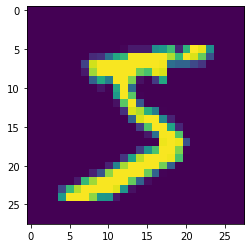

In [ ]:
plt.imshow(x_train_orig[0])

In [ ]:
x_train_orig = x_train_orig.reshape(-1, 28, 28, 1)

In [ ]:
data_gen = ImageDataGenerator(rotation_range=10, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=False,
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [ ]:
x_generated, y_generated = next(data_gen.flow(
                                                x_train_orig.reshape(-1, 28, 28, 1), 
                                                y_train_orig, 
                                                batch_size=5000,
                                                shuffle=True
                                              ))
x_generated = x_generated.reshape((-1, 784))
y_generated = to_categorical(y_generated)

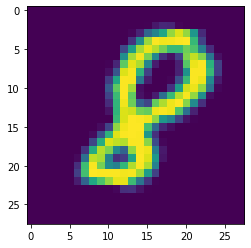

In [ ]:
plt.imshow(x_generated[0].reshape(28,28))

In [ ]:
# normaliza los valores de los pixels de entrada al rango 0-1
x_train = np.reshape(x_train_orig / 255, (-1, 784))
x_test = np.reshape(x_test_orig / 255, (-1, 784))

# convierte los datos numéricos de salida a su representación one-hot
y_train = to_categorical(y_train_orig)
y_test = to_categorical(y_test_orig)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [ ]:
x_train = np.concatenate([x_train, x_generated], axis = 0)
y_train = np.concatenate([y_train, y_generated ], axis = 0)

## Modelo

In [ ]:
def nn_init(lsize):
    # nombres de las capas legibles para humanos para mayor claridad
    input_layer  = lsize[0]
    hidden_1     = lsize[1]
    hidden_2     = lsize[2]
    output_layer = lsize[3]
    
    # reduciendo la desviación estándar por tamaño de capa, con np.sqrt()
    # las capas grandes tienen valores iniciales más ajustados
    nnet = {
        'w0': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
        'w1': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
        'w2': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
    }
    return nnet

# definición de unidades x capas (de entrada, ocultas y de salida)
layer_sizes = [x_train[0].shape[0], 256, 128, y_train[0].shape[0]]
model = nn_init(layer_sizes)

In [ ]:
layer_sizes

[784, 256, 128, 10]

In [ ]:
# simula la red evaluandola mediante la propagación hacia delante
def forward_pass(x):
    # el modelo es una variable global, utilizada aquí de solo lectura
    
    # Estado NN: sumas internas, salidas de neuronas
    nn_state = {}
    
    # "salida cero" es la salida de los receptores = entrada a la primera capa en el NN
    # estas son activaciones para la capa de entrada
    nn_state['o0'] = x
    
    # de la capa de entrada a la capa oculta 1
    # suma ponderada de todas las activaciones, luego activación sigmoide
    nn_state['z1'] = np.dot(model['w0'], nn_state['o0'])
    nn_state['o1'] = relu(nn_state['z1']) #####                 HERE
    
    # de la capa oculta 1 a la capa oculta 2
    nn_state['z2'] = np.dot(model['w1'], nn_state['o1'])
    nn_state['o2'] = relu(nn_state['z2']) #####                 HERE
    
    # de la capa oculta 2 a la salida
    nn_state['z3'] = np.dot(model['w2'], nn_state['o2'])
    nn_state['o3'] = softmax(nn_state['z3'])

    
    return nn_state

# calcula los gradientes mediante las derivadas parciales del error los 
# pesos de todas las capas
def backward_pass(x, y):
    # hacer la propagación hacia adelante, registra el estado de la red
    nn_state = forward_pass(x)
    
    # pequeños deltas: derivadas del error con respecto a z
    nn_state['d3'] = nn_state['o3'] - y
    nn_state['d2'] = np.dot(nn_state['d3'], model['w2']) * softmax(nn_state['z2'], derivative = True)
    nn_state['d1'] = np.dot(nn_state['d2'], model['w1']) * relu(nn_state['z1'], derivative = True) ####             HERE
    
    # grandes deltas: ajustes de pesos
    nn_state['D2'] = np.outer(nn_state['d3'], nn_state['o2'])
    nn_state['D1'] = np.outer(nn_state['d2'], nn_state['o1'])
    nn_state['D0'] = np.outer(nn_state['d1'], nn_state['o0'])
    
    return nn_state

# calcula la función de costo de entropía cruzada binaria
def part_cost(o, y):
    c = np.dot(y, np.log(o)) + np.dot((1 - y), np.log(1 - o))
    return -c

# calcula la función de activación sigmoidea y su derivada
def sigmoid(x, derivative = False):
    if derivative:
        return np.exp(-x) / ((np.exp(-x) + 1) ** 2)
    else:
        return 1 / (1 + np.exp(-x))

def relu(x, derivative= False):
    if derivative:
        x[x>0] = 1
        x[x<=0] = 0
        return x
    else:
        return np.maximum(0, x)

# calcula la función de activación softmax y su derivada
def softmax(x, derivative = False):
    # para la estabilidad, cambiamos los valores hacia abajo para que max = 0
    # https://cs231n.github.io/linear-classify/#softmax
    exp_shifted = np.exp(x - x.max())
    if derivative:
        return exp_shifted / np.sum(exp_shifted, axis = 0) * (1 - exp_shifted / np.sum(exp_shifted, axis = 0))
    else:
        return exp_shifted / np.sum(exp_shifted, axis = 0)

In [ ]:
x_train.shape

(65000, 784)

In [ ]:
y_train.shape

(65000, 10)

In [ ]:
# hiperparámetros
epochs = 5     # número de epocas de entrenamiento
t_rate = 0.01  # razón de aprendizaje

# entrena
print('################### entrenando ####################')
for e in range(epochs):
    print('epoca:', e)
    
    samples = x_train.shape[0]
    cost = 0
    hit_count = 0
    for i in tqdm(range(samples)):
        m_state = backward_pass(x_train[i], y_train[i])
        # add partial cost
        cost += part_cost(m_state['o3'], y_train[i])
        
        # gradiente descendiente estocástico
        # actualiza los pesos
        model['w0'] -= t_rate * m_state['D0']
        model['w1'] -= t_rate * m_state['D1']
        model['w2'] -= t_rate * m_state['D2']
        
        if np.argmax(m_state['o3']) == np.argmax(y_train[i]):
            # detección exitosa
            hit_count += 1

    # evaluación del desempeño
    cost = cost / samples
    accuracy = hit_count / samples
    print('costo:', cost, 'exactitud:', accuracy)

################### entrenando ####################
epoca: 0


  0%|          | 0/65000 [00:00<?, ?it/s]

costo: 0.706184873935888 exactitud: 0.8706461538461538
epoca: 1


  0%|          | 0/65000 [00:00<?, ?it/s]

costo: 0.4512112668504361 exactitud: 0.9222615384615385
epoca: 2


  0%|          | 0/65000 [00:00<?, ?it/s]

costo: 0.36479284304638093 exactitud: 0.9391076923076923
epoca: 3


  0%|          | 0/65000 [00:00<?, ?it/s]

costo: 0.29800347662932625 exactitud: 0.9498
epoca: 4


  0%|          | 0/65000 [00:00<?, ?it/s]

costo: 0.30389688194493736 exactitud: 0.9511076923076923


In [ ]:
# prueba
import os
import pickle
# salva el modelo usando pickle
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)
    
print('################### evaluando ####################')

# carga el modelo salvado con pickle
if os.path.isfile('model.pickle'):
    with open('model.pickle', 'rb') as f:
        model = pickle.load(f)

# ejecutar todos los datos de prueba
samples = x_test.shape[0]
cost = 0
hit_count = 0
for i in tqdm(range(samples)):
    m_state = forward_pass(x_test[i])
    cost += part_cost(m_state['o3'], y_test[i])
    if np.argmax(m_state['o3']) == np.argmax(y_test[i]):
        hit_count += 1

# evaluar el desempeño
cost = cost / samples
accuracy = hit_count / samples
print('costo:', cost, 'exactitud:', accuracy)

################### evaluando ####################


  0%|          | 0/10000 [00:00<?, ?it/s]

costo: 0.33420997687764936 exactitud: 0.9451


# Muestras de Datos

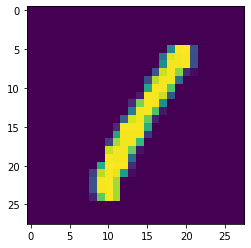

In [ ]:
# graficar la cuarta imagen de entrenamiento
plt.imshow(np.reshape(x_train[3], (28, 28)));

In [ ]:
# resultado esperado para la cuarta imagen
y_train[3].astype(int).tolist()

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

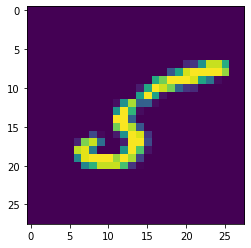

In [ ]:
# grafica la 16va imagen de entrenamiento
plt.imshow(np.reshape(x_train[11], (28, 28)));

In [ ]:
# resultado esperado para la 16va imagen
y_train[11].astype(int).tolist()

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

# Función Sigmoidea

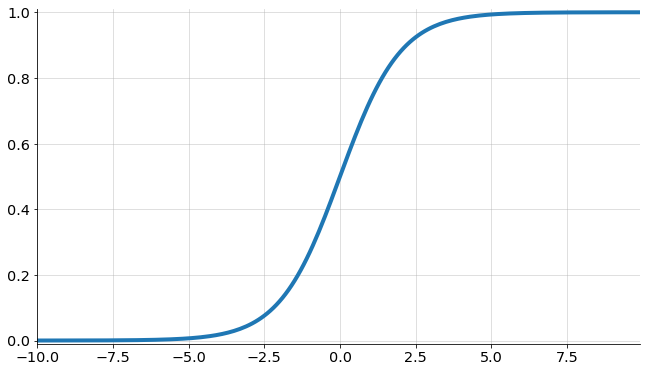

In [ ]:
# grafica la curva sigmoidea
x = np.arange(-10, 10, 0.1)
y = 1 / (1 + np.exp(-x))
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['lines.marker'] = ''
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'
plt.rcParams['figure.subplot.top'] = 0.98
plt.rcParams['figure.subplot.bottom'] = 0.05
plt.rcParams['figure.subplot.left'] = 0.05
plt.rcParams['figure.subplot.right'] = 0.98
plt.plot(x, y);